In [1]:
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu
from scipy.stats import chi2_contingency

## A/B Тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Откроем файл с группами пользователей

In [2]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.shape

(74484, 2)

Проверим, нет ли пропущенных значений в данных.

In [5]:
groups.isnull().sum()

id     0
grp    0
dtype: int64

Проверим, нет ли дубликатов среди id.

In [6]:
groups.id.duplicated().sum()

0

Посчитаем, сколько пользователей в каждой из групп

In [7]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

Откроем файл с информацией о пользователях, заходивших на платформу в дни эксперимента

In [8]:
active_studs = pd.read_csv('Проект_2_active_studs.csv')

In [9]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


Проверим наличие дубликатов

In [10]:
active_studs.duplicated().sum()

0

Откроем файл с информацией об оплатах

In [11]:
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [12]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [13]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Нас интересуют только пользователи, которые заходили на платформу и принадлежат какой-либо из групп, поэтому при объединении таблиц будем использовать inner join.

In [14]:
students = groups.merge(active_studs, left_on='id', right_on='student_id').drop(columns='id')

In [15]:
students.head()

,grp,student_id
0,A,1627
1,B,2085
2,B,2215
3,A,3391
4,B,3401


In [16]:
students.shape

(8328, 2)

Добавим в датафрейм students данные об оплате. Информация о студентах не производивших оплату тоже нужна, поэтому при объединении используем left join.

In [17]:
students = students.merge(checks, how='left', on='student_id')

In [18]:
students

,grp,student_id,rev
0,A,1627,990.0
1,B,2085,NaN
2,B,2215,NaN
3,A,3391,NaN
4,B,3401,NaN
...,...,...,...
8323,B,5681918,1900.0
8324,B,5685258,NaN
8325,B,5688310,NaN
8326,B,5689627,NaN


Посмотрим на численное распределение групп

In [19]:
students.grp.value_counts() 

B    6793
A    1535
Name: grp, dtype: int64

В контрольной группе(А) существенно меньше пользователей, чем в целевой(B)

<b> Выбор метрик <b>

Из представленных данных оценить результаты эксперимента мы можем используя данные об оплатах. В ходе эксперимента меняли механику оплаты, что может влиять на то, смог ли пользователь осуществить оплату (т.е. на конверсию в покупку - CR), и на то, изменилась ли средняя сумма покупки (показатель среднего чека на платящего пользователя - ARPPU)

<b>СR

In [20]:
# CR = 100*количество продаж/количество клиентов
cr_a = round(100 * students.query('grp=="A" and rev>0').student_id.count() / students.grp.value_counts()['A'], 2)
cr_b = round(100 * students.query('grp=="B" and rev>0').student_id.count() / students.grp.value_counts()['B'], 2)
print('Конверсия для контрольной группы А: ', cr_a)
print('Конверсия для целевой группы B: ', cr_b)

Конверсия для контрольной группы А:  5.08
Конверсия для целевой группы B:  4.61


Проверим статистически значимы ли полученные результаты.
<br>Для удобства добавим столбец с данными, произвел ли пользователь оплату.

In [21]:
students['conversion'] = students.rev.apply(lambda x: 1 if x>0 else 0 )

In [22]:
pd.crosstab(students.grp, students.conversion)

conversion,0,1
grp,,
A,1457,78
B,6480,313


Обе переменные категориальные поэтому используем хи-квадрат
<br>H0: взаимосвязи между переменными нет
<br>H1: взаимосвязь между переменными есть

In [23]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(students.grp, students.conversion))
round(p, 2)

0.47

p-value>0.05, поэтому не можем отклонить нулевую гипотезу, а значит не можем говорить что конверсия статистически значимо изменилась.


<b>ARPPU


In [24]:
# ARPPU для группы А
arppu_a = round(students.query('grp=="A"').rev.mean(), 2)
arppu_a

933.59

In [25]:
# ARPPU для группы B
arppu_b = round(students.query('grp=="B"').rev.mean(), 2)
arppu_b

1255.83

Теперь оценим изменение ARPPU. Для начала проверим являются ли распределения в группах нормальными

In [26]:
a = students.query('grp=="A" and rev>0').rev
b = students.query('grp=="B" and rev>0').rev

<AxesSubplot:ylabel='Frequency'>

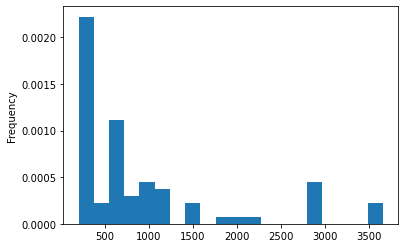

In [27]:
a.plot(kind='hist', density=1, bins=20)

<AxesSubplot:ylabel='Frequency'>

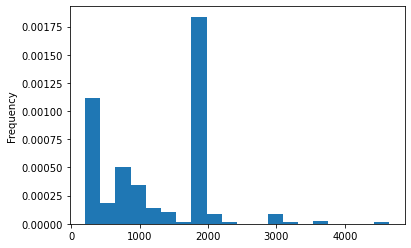

In [28]:
b.plot(kind='hist', density=1, bins=20)

Судя по графикам, распределения не являются нормальными. Удостоверимся, применив тест Шапиро-Уилка.

In [29]:
shapiro(a)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [30]:
shapiro(b)

ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)

Распределения не являются нормальными, т.к. p-value<0.05

Параметрические условия не удовлетворяются и сравниваем 2 группы, поэтому будем использовать U-критерий Манна-Уитни

In [31]:
st, p = mannwhitneyu(a, b)
p

0.0001366223502529715

Значение p-value<0.05, значит различия статистически значимы

### Выводы:
Изменения не повлияли на показатели конверсии, а ARPPU увеличилось, поэтому эксперимент можно считать успешным и новую механику стоит запустить на всех пользователей.

## SQL

### Очень усердные ученики

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
<br>Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.
<br>Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [32]:
import pandahouse as ph

In [33]:
connection_default = dict(
    database='default',
    host='https://clickhouse.lab.karpov.courses',
    user='student',
    password='dpo_python_2020')

Информации за текущий месяц в базе нет, но т.к. данные в базу могут периодически подгружаться и нужна актуальная информация, то сравнивать считаю нужным именно с текущей датой.

In [34]:
query = '''
    SELECT COUNT(st_id) AS num_st
    FROM (
        SELECT st_id
        FROM default.peas
        WHERE toStartOfMonth(timest) = date_trunc('month', now()) --сравниваем с текущим месяцем
        GROUP BY st_id
        HAVING SUM(correct)>=20)
'''
df = ph.read_clickhouse(query, connection=connection_default)
df

,num_st
0,0


### Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
<br>Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [40]:
query = '''
WITH cte AS (
--Подготовим общую таблицу с данными
    SELECT 
        s.st_id AS id, --id всех студентов, участвующих в эксперименте
        s.test_grp AS test_grp, -- группа эксперимента
        st_act.active_st AS active_st, -- метка активности студента
        st_math.math_active AS math_active -- метка активности студента по математике
        ,c.money AS money --сумма оплаты
        ,st_math.money_math AS money_math -- сумма денег по математике
    FROM default.studs s 
    LEFT JOIN( 
        -- Деление студентов на активных(1) и неактивных(0)
        SELECT 
            st_id,
            if(sum(correct)>10, 1, 0) AS active_st
        FROM default.peas 
        GROUP BY st_id 
    ) AS st_act
    ON s.st_id=st_act.st_id
    LEFT JOIN(
        SELECT
            st_id,
            math_active,
            money_math
        FROM(
            --Деление студентов на активных по математике(1) и неактивных по математике(0)
            SELECT 
                st_id,
                if(sum(correct)>=2, 1, 0) AS math_active
            FROM default.peas
            WHERE subject='Math'
            GROUP BY st_id ) as ma
        LEFT JOIN (
            --Выбираем оплаченные суммы по математике
            SELECT st_id, sum(money) as money_math
            FROM default.final_project_check
            WHERE subject='Math'
            GROUP BY st_id) as mm
        ON ma.st_id=mm.st_id
    ) AS st_math
    ON st_math.st_id=s.st_id
    LEFT JOIN 
        (SELECT st_id, sum(money) as money
        FROM default.final_project_check
        GROUP BY st_id) AS c 
        ON s.st_id=c.st_id
)
SELECT 
    test_grp,
    ROUND(sum(money)/COUNT(DISTINCT id), 2) AS ARPU,
    ROUND(sumIf(cte.money, active_st=1 )/countIf(distinct cte.id, cte.active_st=1), 2)AS ARPAU,
    ROUND(100*countIf(cte.money,cte.money>0)/COUNT(DISTINCT id), 2) AS CR,
    ROUND(100*countIf(cte.money,cte.money>0 and active_st=1)/countIf(distinct cte.id, cte.active_st=1),2) AS CR_active,
    ROUND(100*countIf(cte.money_math,cte.money_math>0 and math_active=1)/countIf(distinct cte.id, cte.math_active=1), 2) AS CR_math
    FROM cte
GROUP BY test_grp
'''
df = ph.read_clickhouse(query, connection=connection_default)
df

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


## Python

Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики

In [36]:
def add_data(file):
    
    # Импорт необходимых библиотек
    import pandas as pd
    from scipy.stats import chi2_contingency 
    
    # Чтение данных
    group_add = pd.read_csv(file)
    groups = pd.read_csv('Проект_2_groups.csv', sep=';')
    active_studs = pd.read_csv('Проект_2_active_studs.csv')
    checks = pd.read_csv('Проект_2_checks.csv', sep=';')
    
    # Добавим новые данные в файл с группами
    groups = pd.concat([groups, group_add])
    
    # Объединяем данные 
    students = groups.merge(active_studs, left_on='id', right_on='student_id').drop(columns='id')
    students = students.merge(checks, how='left', on='student_id')
    
    # Расчет CR
    cr_a = round(100 * students.query('grp=="A" and rev>0').student_id.count() / students.grp.value_counts()['A'], 2)
    cr_b = round(100 * students.query('grp=="B" and rev>0').student_id.count() / students.grp.value_counts()['B'], 2)
    
    # Проверим значимы ли различия
    students['conversion'] = students.rev.apply(lambda x: 1 if x > 0 else 0)
    stat, p, dof, expected = chi2_contingency(pd.crosstab(students.grp, students.conversion))
    prob = 0.95
    alpha = 1.0 - prob
    if p <= alpha:
        cr_result = 'Изменения CR значимы'
    else:
        cr_result = 'Изменения CR НЕ значимы'
    
    # Расчет ARPPU
    arppu_a = round(students.query('grp=="A"').rev.mean(), 2)
    arppu_b = round(students.query('grp=="B"').rev.mean(), 2)
    
    # Проверим значимы ли различия
    a = students.query('grp=="A" and rev>0').rev
    b = students.query('grp=="B" and rev>0').rev
    st, p = mannwhitneyu(a, b)
    if p <= alpha:
        arppu_result = 'Изменения ARPPU значимы'
    else:
        arppu_result = 'Изменения ARPPU НЕ значимы'
    df = pd.DataFrame({'group': ['А', 'B'], 'CR': [cr_a, cr_b], 'ARPPU': [arppu_a, arppu_b]})
    result = (cr_result, arppu_result)

    return df, result

In [37]:
res_table, r = add_data('Проект_2_group_add.csv')
display(res_table)
print(r)

,group,CR,ARPPU
0,А,5.07,933.59
1,B,4.62,1257.88


('Изменения CR НЕ значимы', 'Изменения ARPPU значимы')


Реализовать функцию, которая будет строить графики по получаемым метрикам.


In [38]:
def graph(data):
    # импорт библиотек
    import matplotlib.pyplot as plt
    

    # Задаем сетку для 2-х графиков
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # График конверсии
    ax1.set(title='Конверсия в группах')
    ax1.bar(data.group, data.CR, color=('darkblue', 'darkorange'))
    # График ARPPU
    ax2.set(title='ARPPU в группах')
    ax2.bar(data.group, data.ARPPU, color=('darkblue', 'darkorange'))

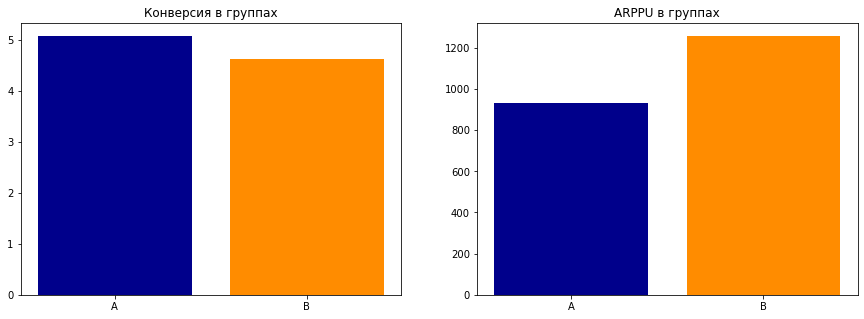

In [39]:
# Вызов функции рисования графиков
graph(res_table)